In [79]:
# LONG/SHORT Statistical Arbitrage Portfolio Strategy

In [1]:
import pandas as pd
import wrds

#connect to WRDS
conn = wrds.Connection()

#get S&P 500 index constituents and their data
sp500 = conn.raw_sql("""
    SELECT a.*, b.date, b.ret, b.shrout, b.prc
    FROM crsp.msp500list as a,
    crsp.msf as b
    WHERE a.permno = b.permno
    AND b.date >= a.start AND b.date <= a.ending
    AND b.date >= '2022-01-01' AND b.date <= '2022-12-31'
    ORDER BY date;
""", date_cols=['start', 'ending', 'date'])


#calculate market capitalization for each row
sp500['mcap'] = sp500['shrout'] * sp500['prc'].abs()

#get total market capitalization for each date
total_mcap = sp500.groupby(['date'])['mcap'].sum().reset_index().rename(columns={'mcap': 'total_mcap'})

#merge total market capitalization with the original dataset
sp500 = pd.merge(sp500, total_mcap, how='left', on='date')

#calculate index weight for each constituent
sp500['weight'] = sp500['mcap'] / sp500['total_mcap']

#get stock symbols for the given permno list
def get_symbols(permno_list):
    query = f"SELECT permno, ticker FROM crsp.stocknames WHERE permno IN ({','.join(map(str, permno_list))})"
    symbols_df = conn.raw_sql(query)
    return symbols_df

# new DataFrame
data = sp500

# get unique permno list and retrieve symbols
unique_permnos = data['permno'].unique()
symbols_df = get_symbols(unique_permnos)

# merge symbols_df with the original data on permno
data_with_symbols = data.merge(symbols_df, on='permno', how='left')

# to rename the column 'ticker' to 'symbol'
data_with_symbols.rename(columns={'ticker': 'Symbol'}, inplace=True)





# Group the data by quarter, symbol and calculate the mean of the weights
data_with_symbols['quarter'] = data_with_symbols['date'].dt.to_period('Q')
quarterly_weights = data_with_symbols.groupby(['quarter', 'Symbol'])['weight'].mean().reset_index()



print(quarterly_weights)


# Save the quarterly weights to a CSV file
quarterly_weights.to_csv('sp500_quarterly_weights_2022.csv', index=False)




import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas_ta as pta
import warnings

warnings.filterwarnings('ignore')

# Fetch S&P 500 constituents
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_constituents = pd.read_html(sp500_url, header=0)[0]
tickers = sp500_constituents['Symbol'].str.replace('.', '-').tolist()

# Remove tickers that are not available
tickers.remove('GEHC')
tickers.remove('GEN')
tickers.remove('RVTY')
tickers.remove('FI')


# Add SPY ETF ticker for benchmark comparison
tickers.append('SPY')

# Set the time period for data
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 12, 31)

# Download the data
complete_data = yf.download(tickers, start=start_date, end=end_date, interval='1h', group_by='ticker', auto_adjust=True)


complete_data.to_csv('stocks_hourly_tickdata_.csv', index=False)



Enter your WRDS username [manish]:mabun
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
     quarter Symbol    weight
0     2022Q1      A  0.001023
1     2022Q1     AA  0.000367
2     2022Q1    AAL  0.000285
3     2022Q1    AAP  0.000335
4     2022Q1   AAPL  0.070878
...      ...    ...       ...
2997  2022Q4   ZBRA  0.000406
2998  2022Q4   ZION  0.000222
2999  2022Q4    ZMH  0.000736
3000  2022Q4    ZTS  0.002045
3001  2022Q4     ZY  0.002603

[3002 rows x 3 columns]
[*********************100%***********************]  500 of 500 completed


# Distribution of index weights - This plot should give a clearer picture of how weights of top 10 companies by index weight change each quarter

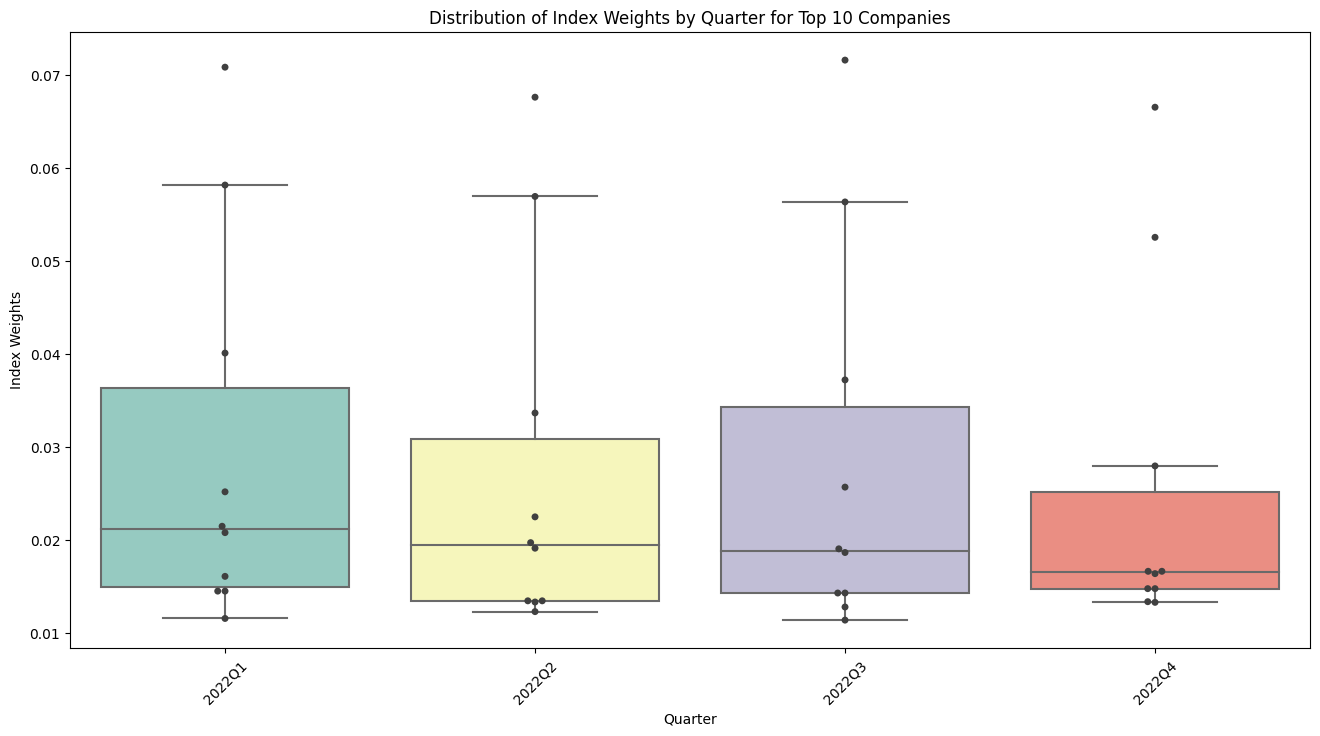

In [5]:
# Calculate top 10 symbols by weight for each quarter
top10_symbols_by_quarter = quarterly_weights.groupby('quarter').apply(lambda x: x.nlargest(10, 'weight')).reset_index(drop=True)

plt.figure(figsize=(16,8))

# Box plot without outliers
sns.boxplot(x='quarter', y='weight', data=top10_symbols_by_quarter, showfliers=False, palette="Set3")

# Swarm plot
sns.swarmplot(x='quarter', y='weight', data=top10_symbols_by_quarter, color=".25")

plt.title('Distribution of Index Weights by Quarter for Top 10 Companies')
plt.ylabel('Index Weights')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.show()


# returns distribution

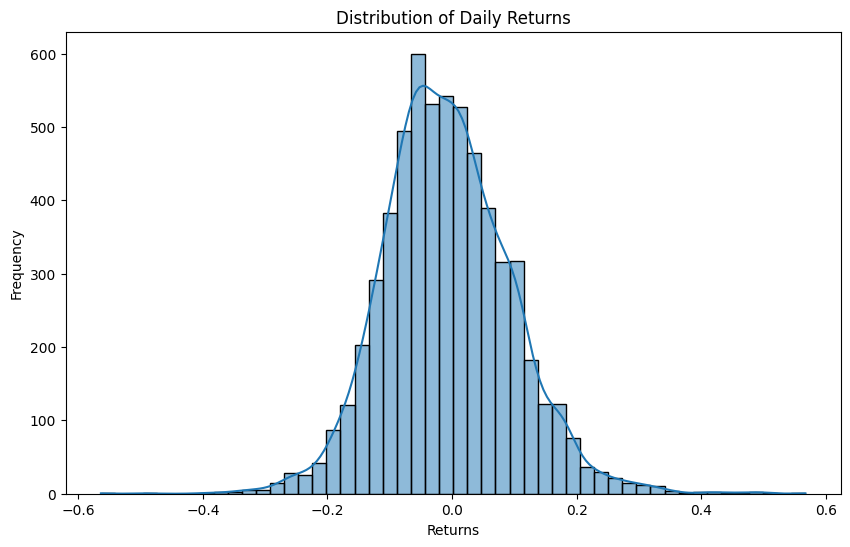

In [3]:
plt.figure(figsize=(10,6))
sns.histplot(data['ret'], bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()


# Mcap over time

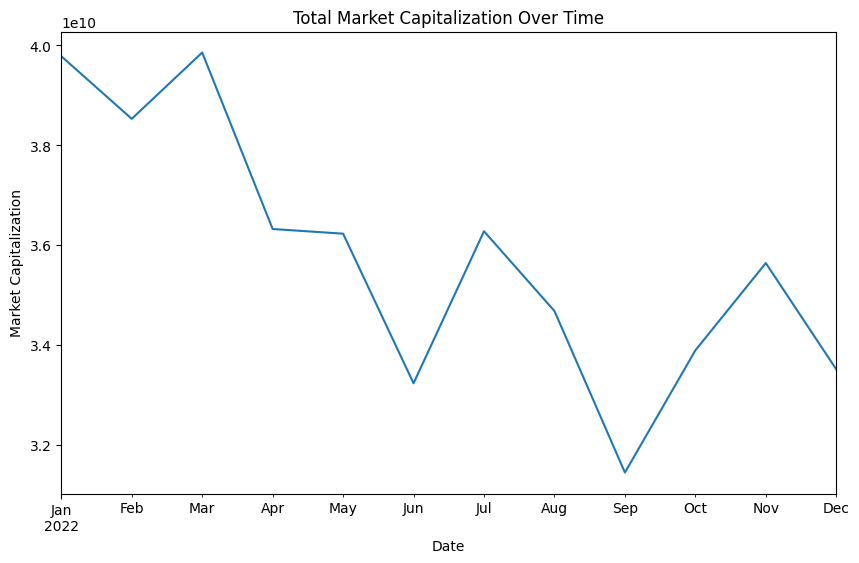

In [4]:
total_mcap['date'] = pd.to_datetime(total_mcap['date'])
total_mcap.set_index('date', inplace=True)

plt.figure(figsize=(10,6))
total_mcap['total_mcap'].plot()
plt.title('Total Market Capitalization Over Time')
plt.ylabel('Market Capitalization')
plt.xlabel('Date')
plt.show()


# Part 2 

In [53]:
# filter data for the desired month
data = complete_data
month1 = 12
month2 = 12
data = data[(data.index.month == month1) | (data.index.month == month2)]





# Load quarterly index weights and map them to the constituents
def get_index_weights_for_quarter(quarter):
    quarterly_weights = pd.read_csv("./sp500_quarterly_weights_2022.csv")
    quarter_weights = quarterly_weights[quarterly_weights['quarter'] == str(quarter)]
    
    # Filter out only the symbols available in yfinance S&P 500
    quarter_weights = quarter_weights[quarter_weights['Symbol'].isin(sp500_constituents['Symbol'])]

    # Normalize the weights for the symbols available in yfinance S&P 500
    quarter_weights['normalized_weight'] = quarter_weights['weight'] / quarter_weights['weight'].sum()
    
    index_weights = dict(zip(quarter_weights['Symbol'], quarter_weights['normalized_weight']))
    return index_weights

# Get the index weights for the desired quarter
quarter = pd.to_datetime('2022-12-31').to_period('Q')  # Replace this with the desired quarter end date
index_weights = get_index_weights_for_quarter(quarter)
sp500_constituents['Index Weight'] = sp500_constituents['Symbol'].map(index_weights)









risk_free_rate = 0.001  # to calculate sharpe ratio, can fetch current Fed rate

#annual_risk_free_rate = risk_free_rate/252  # Considering 252 trading days



daily_risk_free_rate = (1 + risk_free_rate) ** (1/252) - 1



#annual_risk_free_rate = (1 + risk_free_rate) ** (1/252) - 1


# Calculate intraday volatility for each stock
intraday_volatility = {}
for ticker in tickers:
    if ticker == 'SPY':
        continue
    stock_data = data[ticker]
    stock_data['Month'] = stock_data.index.to_period('M').month
    stock_data['Return'] = stock_data['Close'].pct_change()
    stock_data = stock_data[(stock_data['Month'] == month1) | (stock_data['Month'] == month2)]
    intraday_volatility[ticker] = stock_data['Return'].std()

# Find the n most volatile stocks
n_most_volatile = 5
most_volatile_stocks = sorted(intraday_volatility, key=intraday_volatility.get, reverse=True)[:n_most_volatile]
index_weights = {ticker: sp500_constituents.loc[sp500_constituents['Symbol'] == ticker, 'Index Weight'].values[0] for ticker in most_volatile_stocks}

# Define strategies
strategies = ["z_score", "mean_reversion", "moving_average_crossover", "rsi", "bollinger_bands"]

# Initialize the dictionary to store cumulative returns for each strategy
strategy_returns = {
    'z_score': 0,
    'mean_reversion': 0,
    'moving_average_crossover': 0,
    'rsi': 0,
    'bollinger_bands': 0
}



# Data visualisation of n most voaltile stocks - Characterisitcs 

# 1. Daily returns
# 2. Autocorrelation

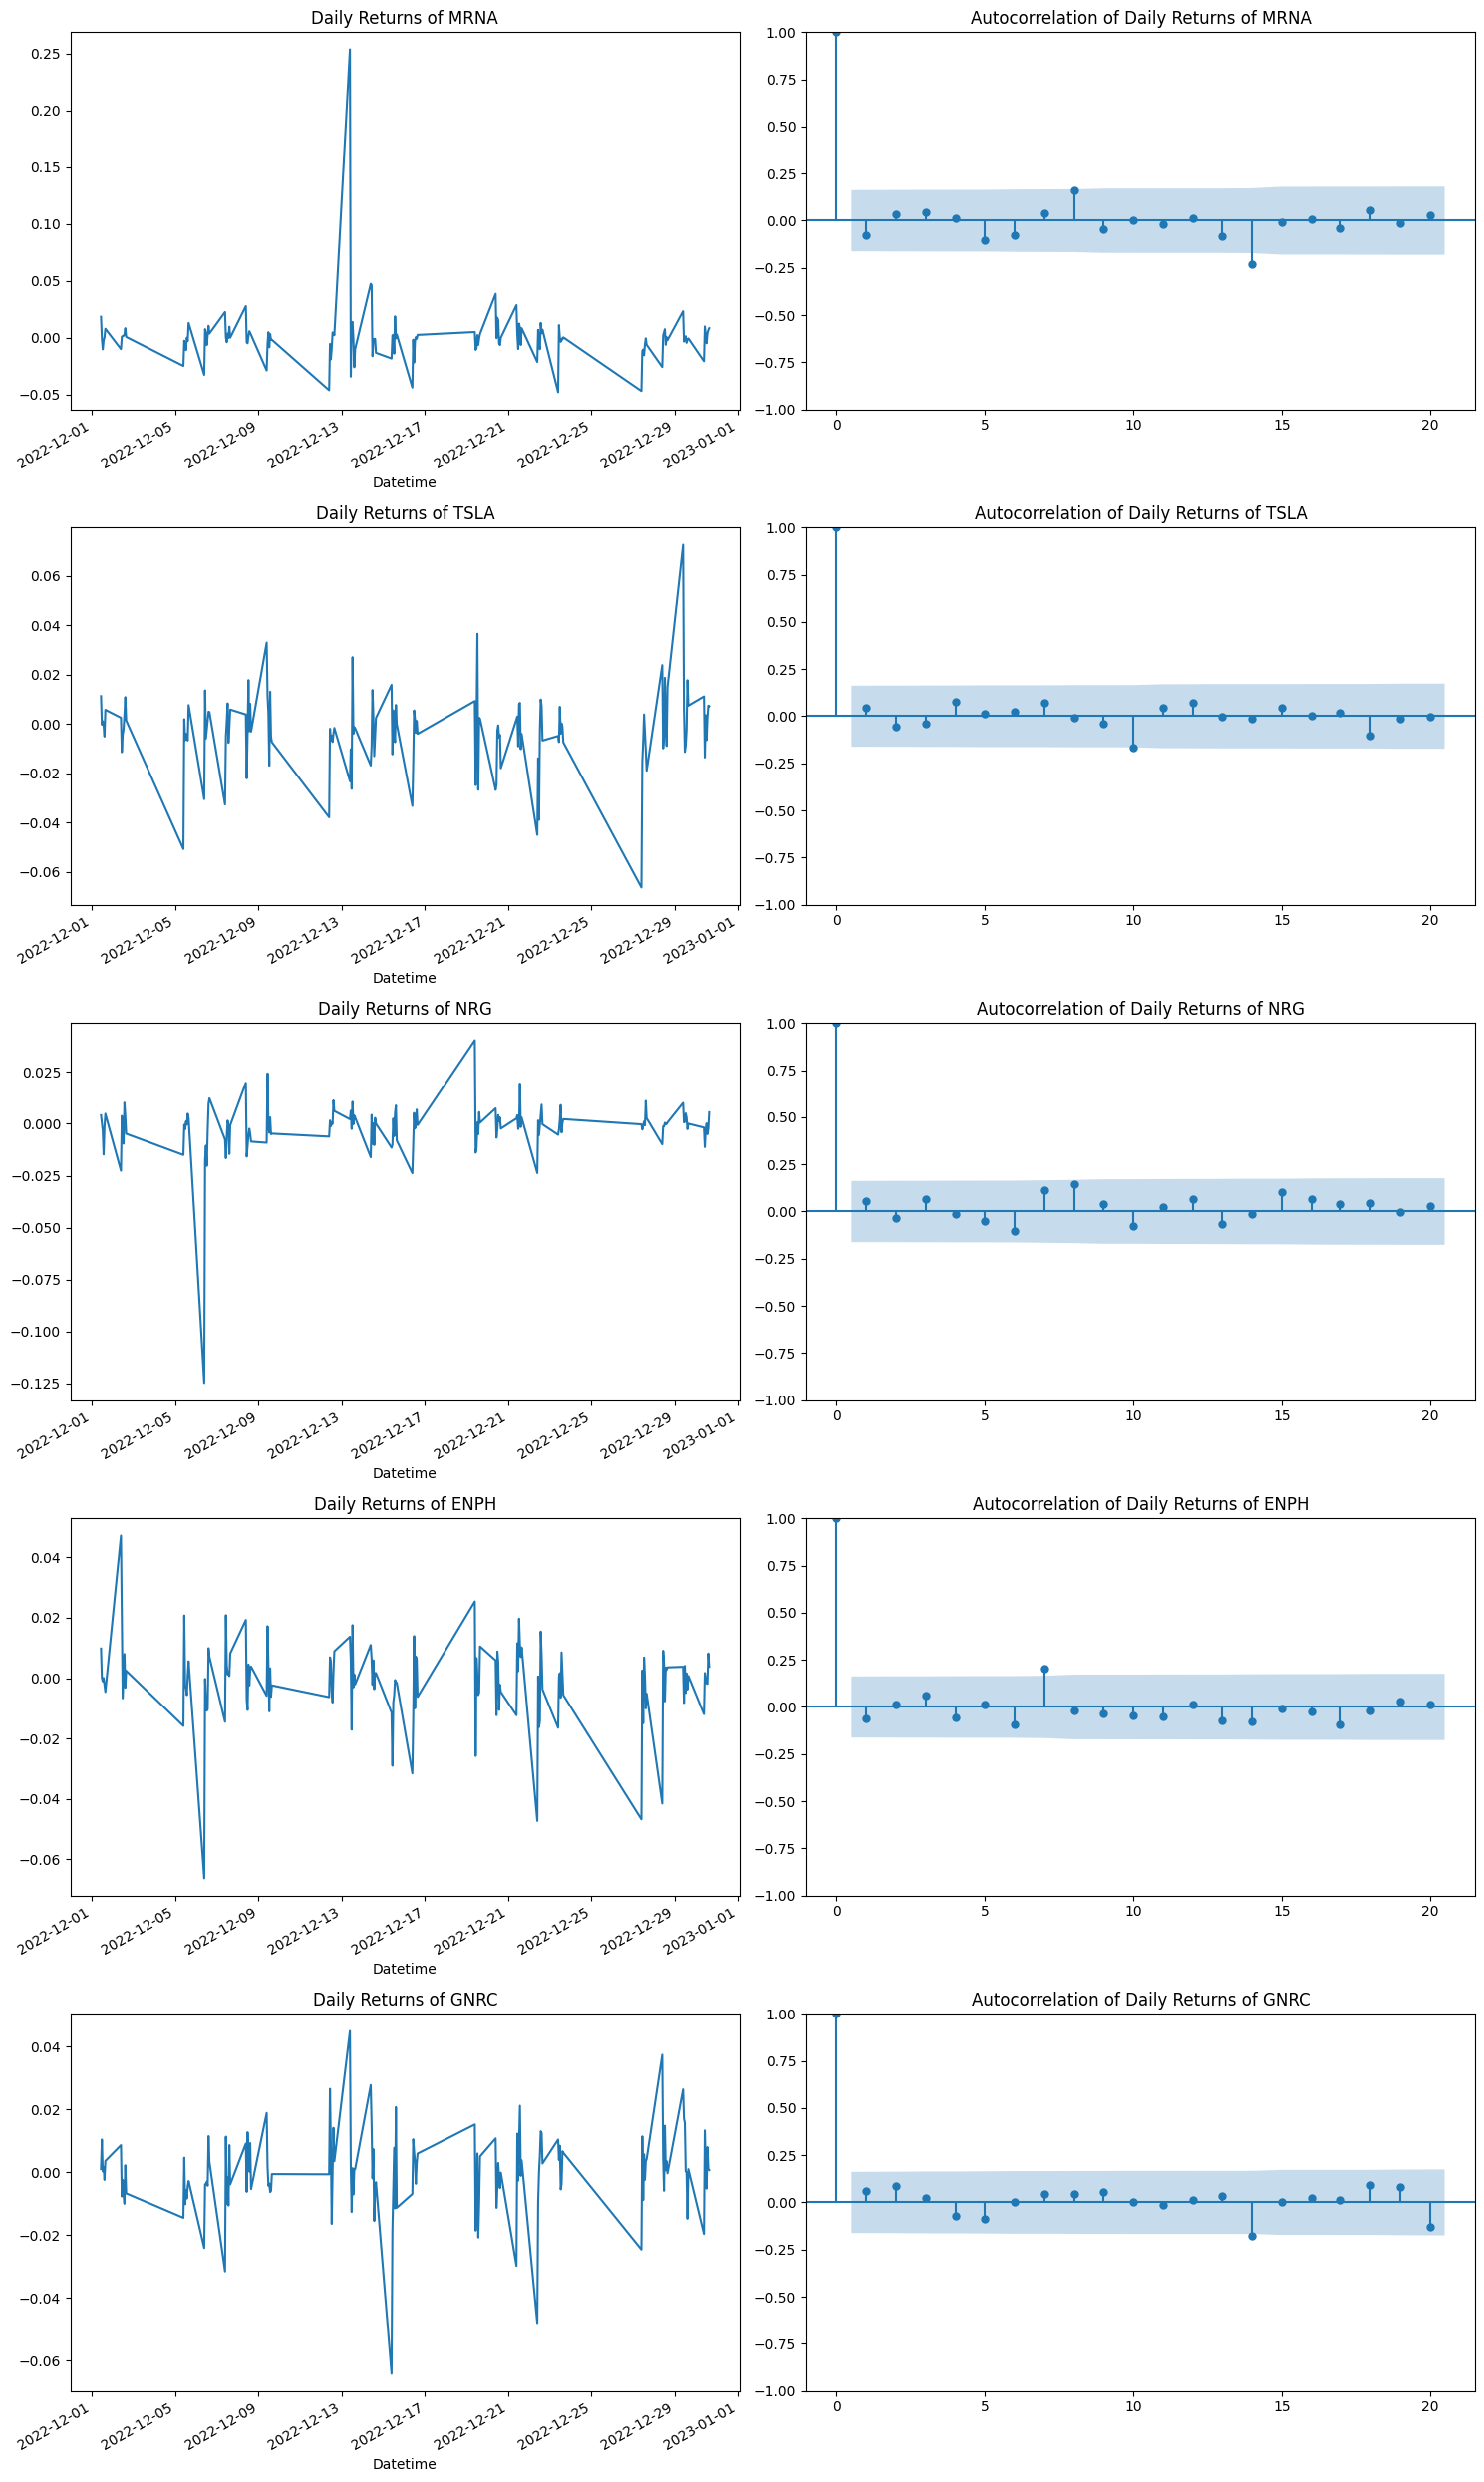

In [54]:
# Plotting daily returns and autocorrelation for the n most volatile stocks
fig, axes = plt.subplots(nrows=len(most_volatile_stocks), ncols=2, figsize=(15, len(most_volatile_stocks)*5))
for i, ticker in enumerate(most_volatile_stocks):
    # Daily Returns
    data[ticker]['Close'].pct_change().plot(ax=axes[i, 0])
    axes[i, 0].set_title(f'Daily Returns of {ticker}')
    
    # Autocorrelation
    plot_acf(data[ticker]['Close'].pct_change().dropna(), lags=20, ax=axes[i, 1])
    axes[i, 1].set_title(f'Autocorrelation of Daily Returns of {ticker}')

plt.tight_layout()
plt.show()


## Daily Returns: This graph shows the day-to-day percentage change in the stock price. It's a measure of the stock's volatility. High volatility can present more opportunities for a trading strategy, but it can also present more risk.

## Autocorrelation: Autocorrelation plots show the correlation of the stock's returns with its past returns. If returns show a significant autocorrelation, it may suggest that the stock's price is predictable to some extent, which could be useful for certain trading strategies. However, efficient market theory suggests that stock returns should not be predictable, so significant autocorrelation could be a sign of a structural issue or anomaly.

## Analysis of the autocorrelation - In an autocorrelation plot, the blue shaded region represents the confidence intervals, typically set to 95%. This means if the autocorrelation is above the upper bound or below the lower bound of this blue region, we can reject the null hypothesis that the true autocorrelation is zero with a 95% confidence. This is crucial as an autocorrelation value close to 0 indicates no linear relationship.

# 7-day rolling average of the stock's returns, along with 1.5 standard deviations of 20 day returns above and below the mean

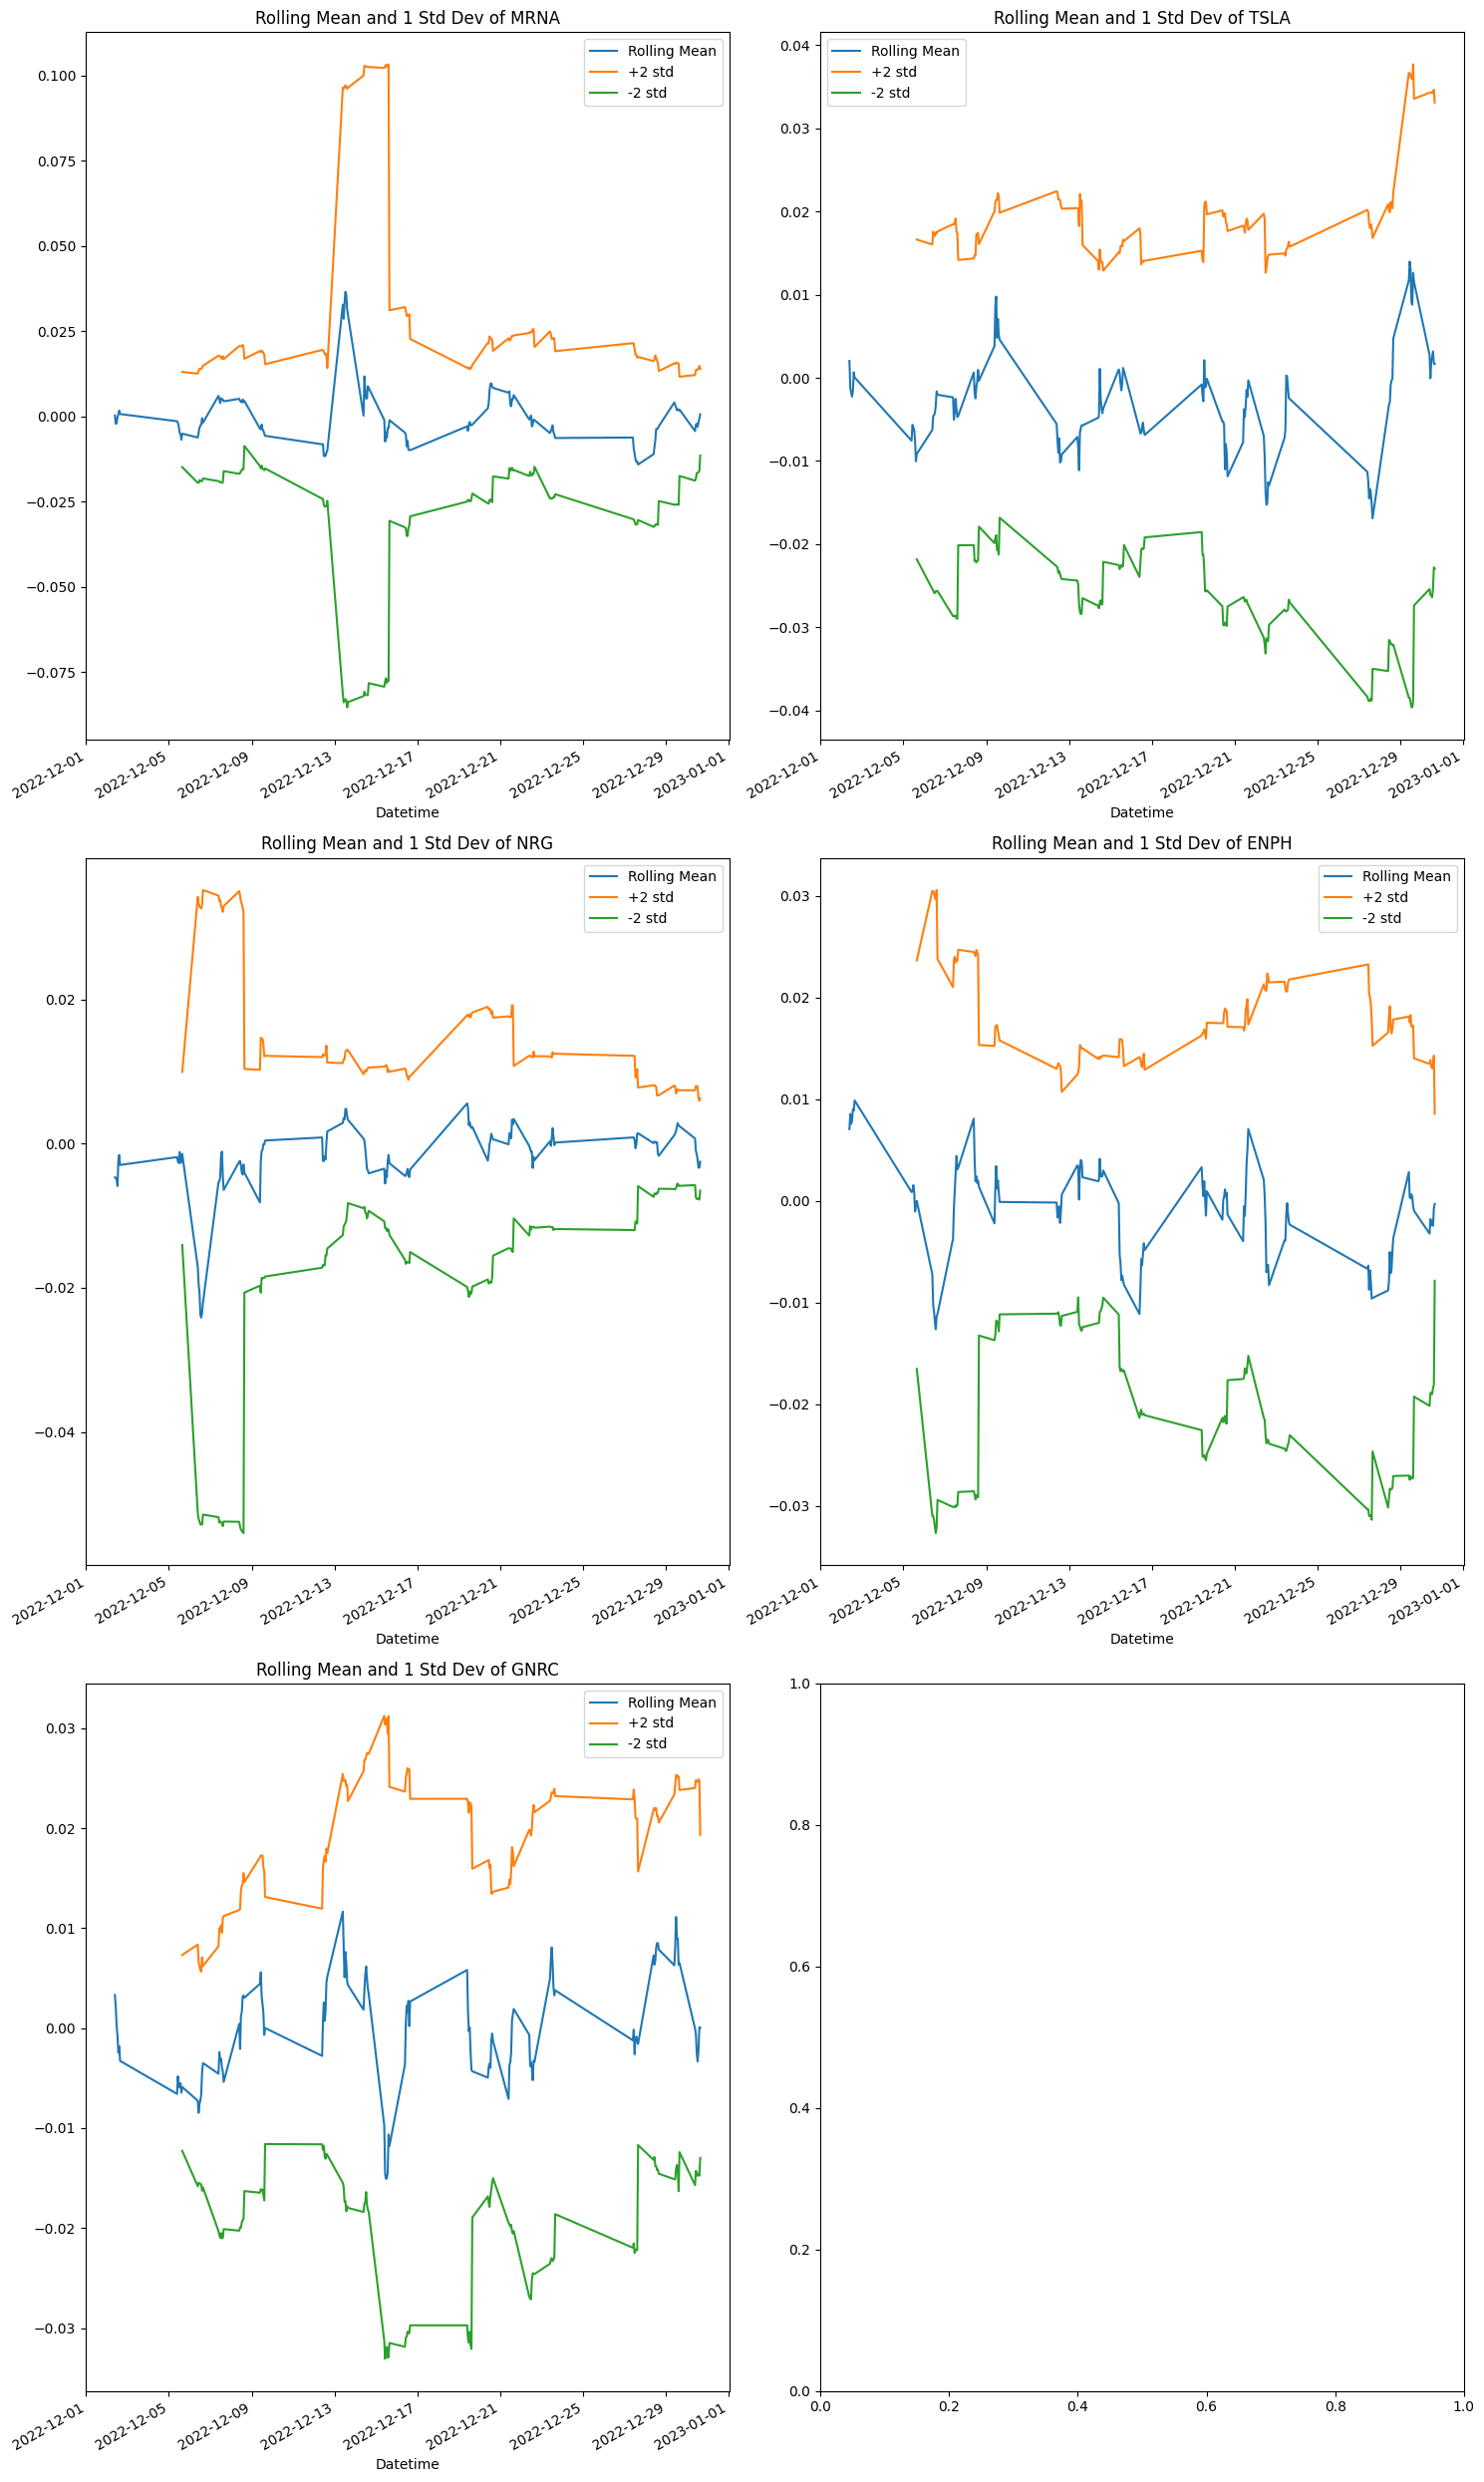

In [55]:
# Plotting rolling 1 standard deviation for the n most volatile stocks
fig, axes = plt.subplots(nrows=int(np.ceil(len(most_volatile_stocks)/2)), ncols=2, figsize=(15, len(most_volatile_stocks)*5))
for i, ticker in enumerate(most_volatile_stocks):
    # Calculate row and column for plotting
    row = i // 2
    col = i % 2

    # Calculate returns
    returns = data[ticker]['Close'].pct_change()

    # Plot rolling mean and 1 standard deviation
    returns.rolling(7).mean().plot(ax=axes[row, col], label='Rolling Mean')
    (returns.rolling(20).mean() + 1.5*returns.rolling(20).std()).plot(ax=axes[row, col], label='+2 std')
    (returns.rolling(20).mean() - 1.5*returns.rolling(20).std()).plot(ax=axes[row, col], label='-2 std')
    axes[row, col].set_title(f'Rolling Mean and 1 Std Dev of {ticker}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()


## When the returns exceed +1.5 or -1.5 standard deviations, it might be considered an unusually large change. This could be interpreted as a sign that the stock is overbought or oversold, potentially presenting a trading opportunity. 

In [92]:
import pandas as pd
import numpy as np
import pandas_ta as pta



portfolios = {}



#data = {}  # placeholder for your data, replace it with your own
#most_volatile_stocks = []  # placeholder for most volatile stocks
#index_weights = {}  # placeholder for index weights
strategies = ["z_score", "mean_reversion", "moving_average_crossover", "rsi", "bollinger_bands"]
strategy_returns = {}

for strategy in strategies:
    portfolio = pd.DataFrame(index=data.index, columns=most_volatile_stocks)

    for ticker in most_volatile_stocks:
        stock_data = data[ticker].copy()
        stock_data['Return'] = stock_data['Close'].pct_change()

        if strategy == "z_score":
            stock_data['Z-Score'] = (stock_data['Return'] - stock_data['Return'].rolling(30).mean()) / stock_data['Return'].rolling(30).std()
            stock_data['Long Signal'] = stock_data['Z-Score'] < -1
            stock_data['Short Signal'] = stock_data['Z-Score'] > 1

        elif strategy == "mean_reversion":
            stock_data['Mean'] = stock_data['Close'].rolling(30).mean()
            stock_data['Long Signal'] = stock_data['Close'] < stock_data['Mean']
            stock_data['Short Signal'] = stock_data['Close'] > stock_data['Mean']

        elif strategy == "moving_average_crossover":
            stock_data['SMA20'] = stock_data['Close'].rolling(20).mean()
            stock_data['SMA50'] = stock_data['Close'].rolling(50).mean()
            stock_data['Long Signal'] = stock_data['SMA20'] > stock_data['SMA50']
            stock_data['Short Signal'] = stock_data['SMA20'] < stock_data['SMA50']

        elif strategy == "rsi":
            stock_data['RSI'] = pta.rsi(stock_data['Close'], length=14)
            stock_data['Long Signal'] = stock_data['RSI'] < 30
            stock_data['Short Signal'] = stock_data['RSI'] > 70

        elif strategy == "bollinger_bands":
            bbands = pta.bbands(stock_data['Close'], length=20)
            stock_data['BBUpper'] = bbands['BBU_20_2.0']
            stock_data['BBMiddle'] = bbands['BBM_20_2.0']
            stock_data['BBLower'] = bbands['BBL_20_2.0']

            stock_data['Long Signal'] = stock_data['Close'] < stock_data['BBLower']
            stock_data['Short Signal'] = stock_data['Close'] > stock_data['BBUpper']

        stock_data['Position'] = 0
        stock_data['Value'] = 0

        initial_investment = 100
        stock_data['Value'].iloc[0] = initial_investment

        for i in range(1, len(stock_data)):
            idx = stock_data.index[i]
            if stock_data.loc[idx, 'Long Signal']:
                stock_data.loc[idx, 'Position'] = index_weights[ticker]
            elif stock_data.loc[idx, 'Short Signal']:
                stock_data.loc[idx, 'Position'] = -index_weights[ticker]
            else:
                stock_data.loc[idx, 'Position'] = stock_data.loc[stock_data.index[i - 1], 'Position']
            
            stock_data.loc[idx, 'Value'] = stock_data.loc[stock_data.index[i - 1], 'Value'] * (1 + stock_data.loc[idx, 'Return'] * stock_data.loc[idx, 'Position'])

        portfolio[ticker] = stock_data['Position']
        
    

    portfolio['Total Position'] = portfolio.sum(axis=1)
    portfolio['Return'] = portfolio['Total Position'] * stock_data['Return']
    portfolio['Value'] = (1 + portfolio['Return']).cumprod()
    portfolio['Cumulative Return'] = portfolio['Value'].iloc[-1] - 1

    cumulative_return = portfolio['Cumulative Return'].iloc[-1]

    print("Strategy:", strategy)
    print("Most volatile stocks:", most_volatile_stocks)
    print("Cumulative Return:", cumulative_return)
    
    # Original annual risk-free rate
    annual_risk_free_rate = 0.001

    # Convert to daily
    daily_risk_free_rate = np.power(1 + annual_risk_free_rate, 1/252) - 1

    # Identify the last non-NaN cumulative return
    last_valid_index = portfolio['Cumulative Return'].last_valid_index()

    # Limit the data used in the Sharpe ratio calculation
    limited_portfolio = portfolio.loc[:last_valid_index]

    excess_return = limited_portfolio['Return'] - daily_risk_free_rate/100
    sharpe_ratio = np.sqrt(252) * (excess_return.mean() / excess_return.std())
    print("Sharpe Ratio: " + str(sharpe_ratio))

    strategy_returns[strategy] = cumulative_return
    
    portfolios[strategy] = portfolio


total_return = sum(strategy_returns.values())
strategy_weights = {k: v / total_return for k, v in strategy_returns.items()}

Strategy: z_score
Most volatile stocks: ['MRNA', 'TSLA', 'NRG', 'ENPH', 'GNRC']
Cumulative Return: -0.21713093911332493
Sharpe Ratio: -4.225408819057586
Strategy: mean_reversion
Most volatile stocks: ['MRNA', 'TSLA', 'NRG', 'ENPH', 'GNRC']
Cumulative Return: -0.05510080084728086
Sharpe Ratio: -1.1402361114833086
Strategy: moving_average_crossover
Most volatile stocks: ['MRNA', 'TSLA', 'NRG', 'ENPH', 'GNRC']
Cumulative Return: -0.065032514907299
Sharpe Ratio: -0.9114499978236179
Strategy: rsi
Most volatile stocks: ['MRNA', 'TSLA', 'NRG', 'ENPH', 'GNRC']
Cumulative Return: 0.04089537898286455
Sharpe Ratio: 0.7190157522976214
Strategy: bollinger_bands
Most volatile stocks: ['MRNA', 'TSLA', 'NRG', 'ENPH', 'GNRC']
Cumulative Return: 0.006660231394884253
Sharpe Ratio: 0.158502421221479


# Portfolio Visualisation

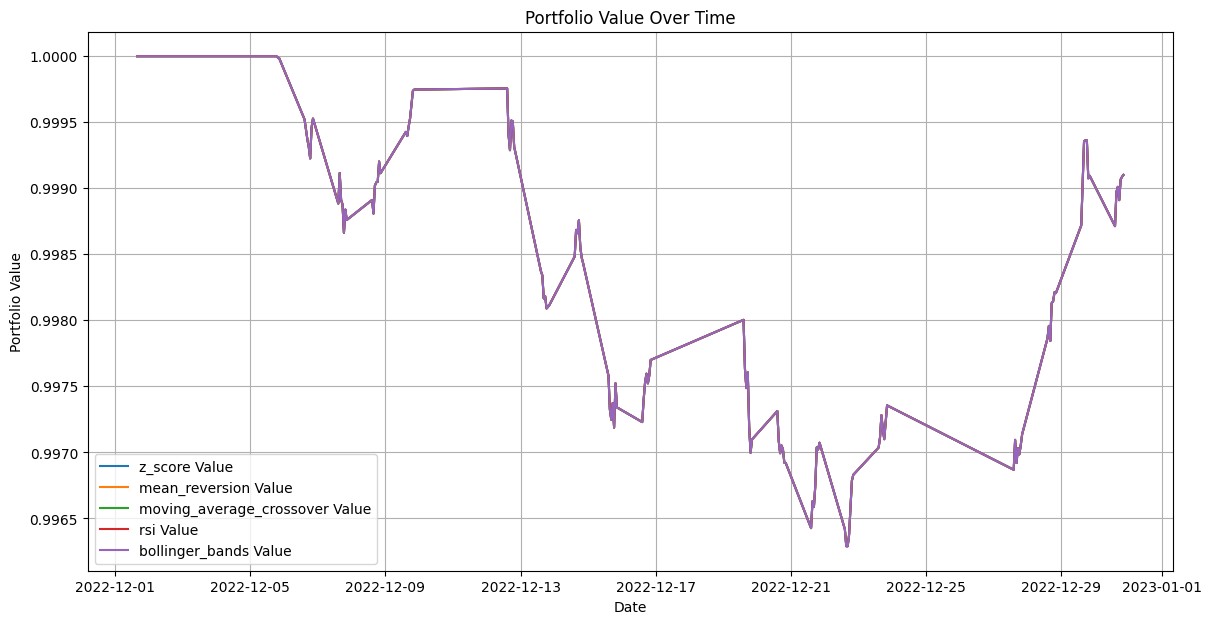

In [72]:
# Portfolio visualisation - 

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for strategy in strategies:
    plt.plot(portfolio['Value'], label=f'{strategy} Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


# 5 Strategy Visualisation for most volatile stocks

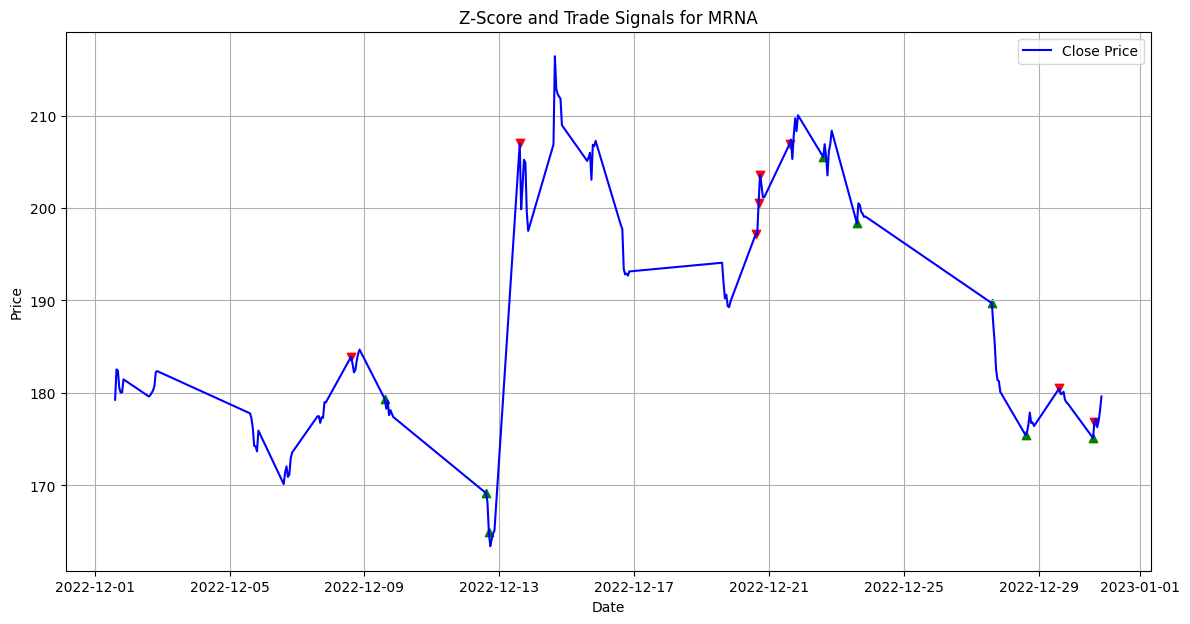

In [65]:
# Assuming 'MRNA' as one of the most volatile stocks, replace with appropriate stock symbol
ticker = 'MRNA'
stock_data = data[ticker].copy()
stock_data['Return'] = stock_data['Close'].pct_change()

# Calculate the Z-Score
stock_data['Z-Score'] = (stock_data['Return'] - stock_data['Return'].rolling(30).mean()) / stock_data['Return'].rolling(30).std()

# Generate signals
stock_data['Long Signal'] = stock_data['Z-Score'] < -1
stock_data['Short Signal'] = stock_data['Z-Score'] > 1

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.scatter(stock_data[stock_data['Long Signal']].index, stock_data[stock_data['Long Signal']]['Close'], color='green', marker='^')
plt.scatter(stock_data[stock_data['Short Signal']].index, stock_data[stock_data['Short Signal']]['Close'], color='red', marker='v')
plt.title(f'Z-Score and Trade Signals for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


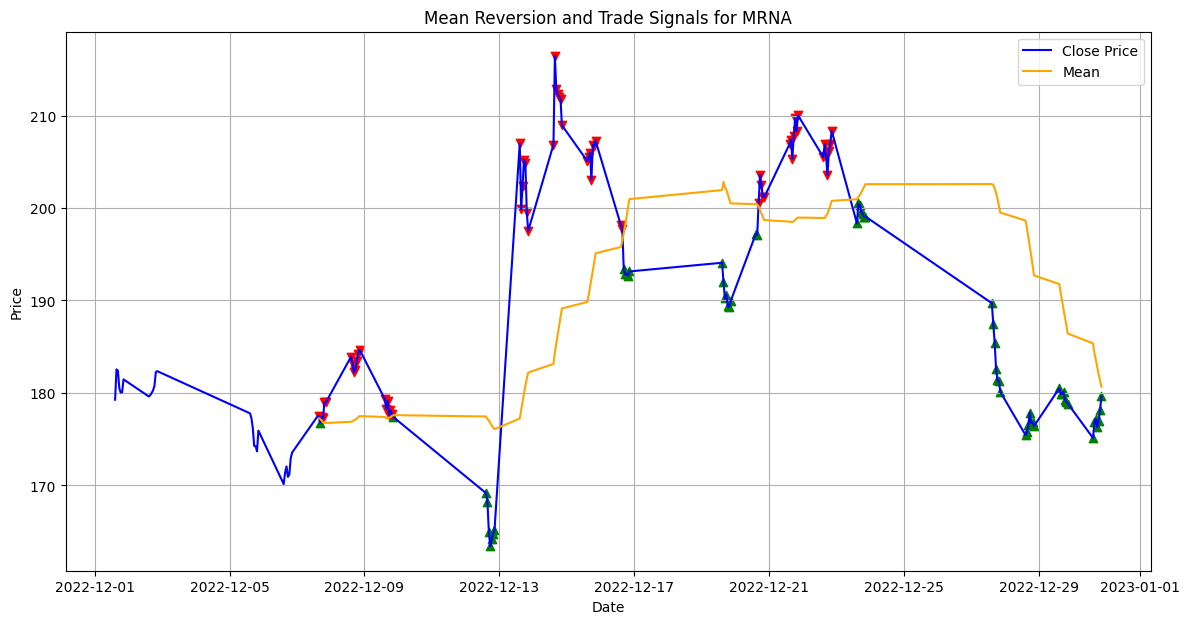

In [66]:
# Calculate the mean
stock_data['Mean'] = stock_data['Close'].rolling(30).mean()

# Generate signals
stock_data['Long Signal'] = stock_data['Close'] < stock_data['Mean']
stock_data['Short Signal'] = stock_data['Close'] > stock_data['Mean']

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['Mean'], label='Mean', color='orange')
plt.scatter(stock_data[stock_data['Long Signal']].index, stock_data[stock_data['Long Signal']]['Close'], color='green', marker='^')
plt.scatter(stock_data[stock_data['Short Signal']].index, stock_data[stock_data['Short Signal']]['Close'], color='red', marker='v')
plt.title(f'Mean Reversion and Trade Signals for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


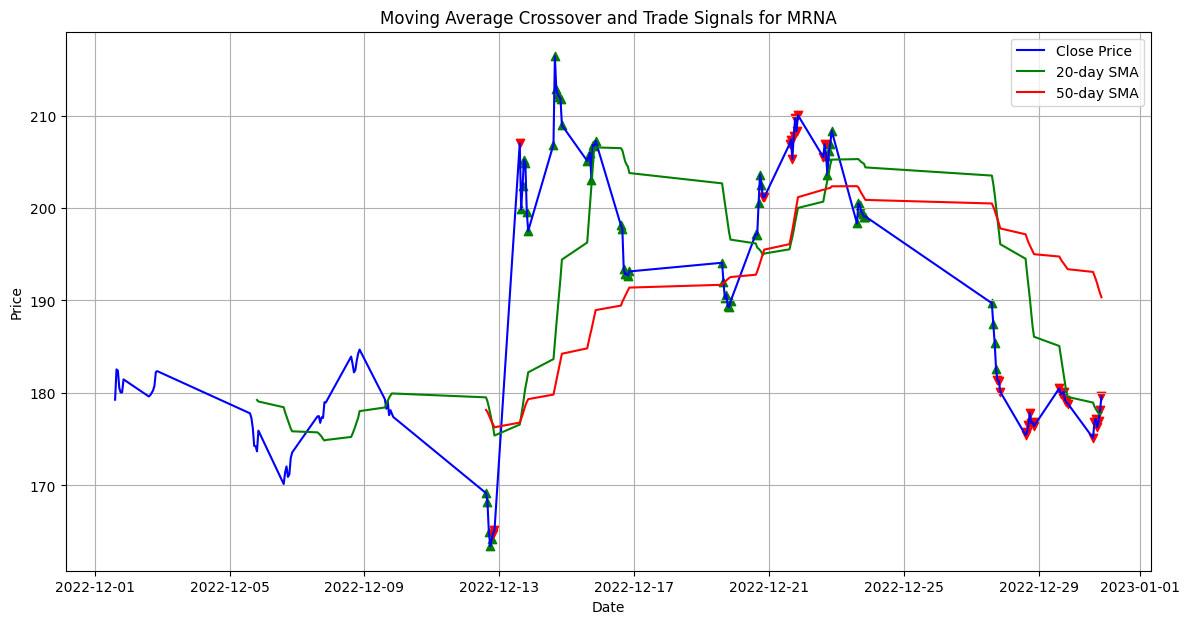

In [67]:
# Calculate the moving averages
stock_data['SMA20'] = stock_data['Close'].rolling(20).mean()
stock_data['SMA50'] = stock_data['Close'].rolling(50).mean()

# Generate signals
stock_data['Long Signal'] = stock_data['SMA20'] > stock_data['SMA50']
stock_data['Short Signal'] = stock_data['SMA20'] < stock_data['SMA50']

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['SMA20'], label='20-day SMA', color='green')
plt.plot(stock_data['SMA50'], label='50-day SMA', color='red')
plt.scatter(stock_data[stock_data['Long Signal']].index, stock_data[stock_data['Long Signal']]['Close'], color='green', marker='^')
plt.scatter(stock_data[stock_data['Short Signal']].index, stock_data[stock_data['Short Signal']]['Close'], color='red', marker='v')
plt.title(f'Moving Average Crossover and Trade Signals for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


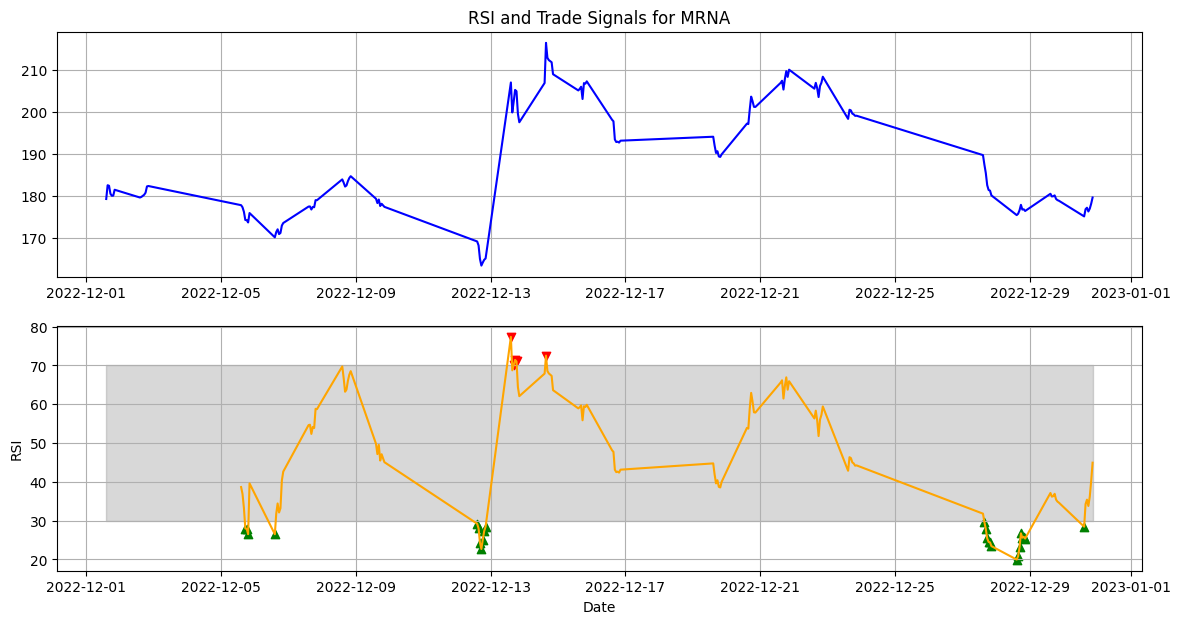

In [68]:
# Calculate RSI
stock_data['RSI'] = pta.rsi(stock_data['Close'], length=14)

# Generate signals
stock_data['Long Signal'] = stock_data['RSI'] < 30
stock_data['Short Signal'] = stock_data['RSI'] > 70

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.title(f'RSI and Trade Signals for {ticker}')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(stock_data['RSI'], label='RSI', color='orange')
plt.fill_between(stock_data.index, 30, 70, color='grey', alpha=0.3)
plt.scatter(stock_data[stock_data['Long Signal']].index, stock_data[stock_data['Long Signal']]['RSI'], color='green', marker='^')
plt.scatter(stock_data[stock_data['Short Signal']].index, stock_data[stock_data['Short Signal']]['RSI'], color='red', marker='v')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.show()


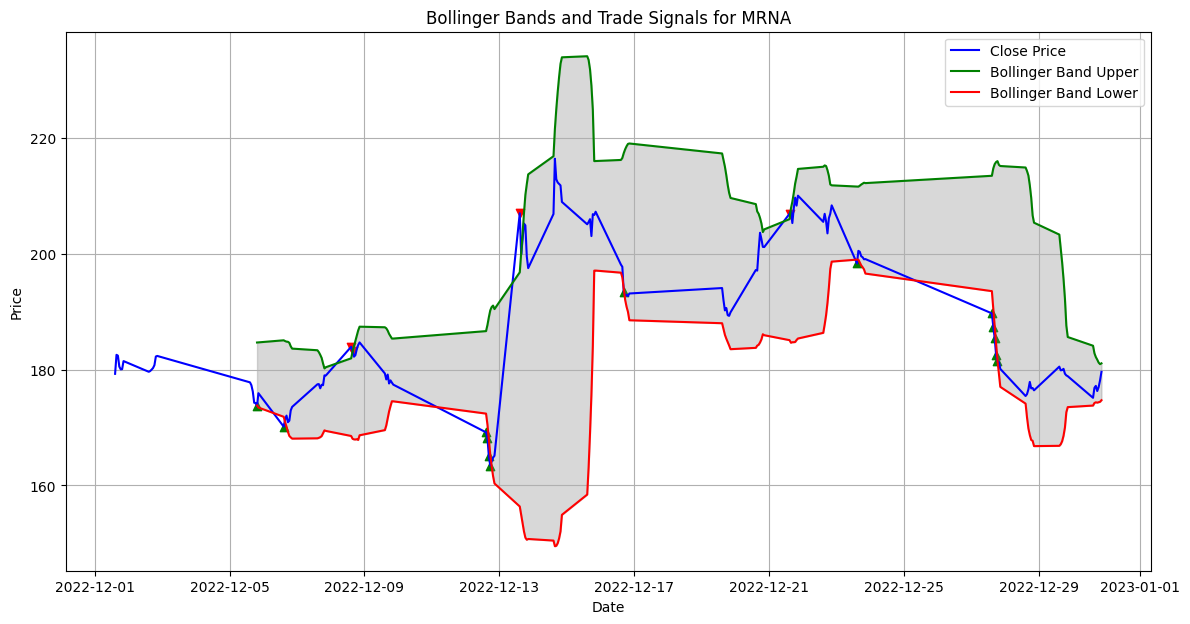

In [69]:
import matplotlib.pyplot as plt

# Assuming 'AAPL' as one of the most volatile stocks, replace with appropriate stock symbol
ticker = 'MRNA'  
stock_data = data[ticker]

# Generate Bollinger Bands
bbands = pta.bbands(stock_data['Close'], length=20)
stock_data['BBUpper'] = bbands['BBU_20_2.0']
stock_data['BBMiddle'] = bbands['BBM_20_2.0']
stock_data['BBLower'] = bbands['BBL_20_2.0']

# Generate signals
stock_data['Long Signal'] = stock_data['Close'] < stock_data['BBLower']
stock_data['Short Signal'] = stock_data['Close'] > stock_data['BBUpper']

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['BBUpper'], label='Bollinger Band Upper', color='green')
plt.plot(stock_data['BBLower'], label='Bollinger Band Lower', color='red')
plt.scatter(stock_data[stock_data['Long Signal']].index, stock_data[stock_data['Long Signal']]['Close'], color='green', marker='^')
plt.scatter(stock_data[stock_data['Short Signal']].index, stock_data[stock_data['Short Signal']]['Close'], color='red', marker='v')
plt.fill_between(stock_data.index, stock_data['BBLower'], stock_data['BBUpper'], color='grey', alpha=0.3)
plt.title(f'Bollinger Bands and Trade Signals for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Combined strategy

In [87]:
def combined_strategy(data):
    portfolio = pd.DataFrame(index=data.index, columns=most_volatile_stocks)

    for ticker in most_volatile_stocks:
        stock_data = data[ticker].copy()
        stock_data['Return'] = stock_data['Close'].pct_change()

        # My strategies...
        
        
        
        
        # Z-Score
        stock_data['Z-Score'] = (stock_data['Return'] - stock_data['Return'].rolling(30).mean()) / stock_data['Return'].rolling(30).std()

        # Mean Reversion
        stock_data['Mean'] = stock_data['Close'].rolling(30).mean()
        stock_data['Mean_Reversion_Signal'] = np.where(stock_data['Close'] < stock_data['Mean'], 1, -1)

        # Moving Average Crossover
        stock_data['SMA20'] = stock_data['Close'].rolling(20).mean()
        stock_data['SMA50'] = stock_data['Close'].rolling(50).mean()
        stock_data['MAC_Signal'] = np.where(stock_data['SMA20'] > stock_data['SMA50'], 1, -1)

        # RSI
        stock_data['RSI'] = pta.rsi(stock_data['Close'], length=14)
        stock_data['RSI_Signal'] = np.where(stock_data['RSI'] < 30, 1, np.where(stock_data['RSI'] > 70, -1, 0))

        # Bollinger Bands
        bbands = pta.bbands(stock_data['Close'], length=20)
        stock_data['BBUpper'] = bbands['BBU_20_2.0']
        stock_data['BBMiddle'] = bbands['BBM_20_2.0']
        stock_data['BBLower'] = bbands['BBL_20_2.0']
        stock_data['BB_Signal'] = np.where(stock_data['Close'] < stock_data['BBLower'], 1, np.where(stock_data['Close'] > stock_data['BBUpper'], -1, 0))

        # Calculate the combined signal
        stock_data['Combined_Signal'] = (stock_data['Z-Score'] * strategy_weights['z_score'] +
                                         stock_data['Mean_Reversion_Signal'] * strategy_weights['mean_reversion'] +
                                         stock_data['MAC_Signal'] * strategy_weights['moving_average_crossover'] +
                                         stock_data['RSI_Signal'] * strategy_weights['rsi'] +
                                         stock_data['BB_Signal'] * strategy_weights['bollinger_bands'])

        stock_data['Combined_Position'] = np.where(stock_data['Combined_Signal'] > 0, index_weights[ticker], -index_weights[ticker])
        portfolio[ticker] = stock_data['Combined_Position']

    portfolio['Total Position'] = portfolio.sum(axis=1)
    portfolio['Return'] = portfolio['Total Position'] * data['SPY']['Close'].pct_change()
    portfolio['Value'] = (1 + portfolio['Return']).cumprod()
    portfolio['Cumulative Return'] = portfolio['Value'].iloc[-1] - 1

    cumulative_return = portfolio['Cumulative Return'].iloc[-1]

    strategy_sharpe_ratios = {}

    for strategy in strategy_returns.keys():
        excess_return = portfolio['Return'] - daily_risk_free_rate
        sharpe_ratio = np.sqrt(252) * (excess_return.mean() / excess_return.std())
        strategy_sharpe_ratios[strategy] = sharpe_ratio

        print(f"Strategy: {strategy}")
        print(f"Sharpe Ratio: {sharpe_ratio}\n")
    
    # Save the portfolio to a CSV file
    portfolio.to_csv(f'portfolio_performance_combined.csv')

    return portfolio, cumulative_return + 1

# Run the combined strategy
portfolio, combined_return = combined_strategy(data)
print(f"Strategy: combined\nMost volatile stocks: {most_volatile_stocks}\nCumulative Return: {combined_return}")

# Add the Sharpe Ratio for the combined strategy
excess_return_combined = portfolio['Return'] - daily_risk_free_rate/100
sharpe_ratio_combined = np.sqrt(252) * (excess_return_combined.mean() / excess_return_combined.std())
strategy_sharpe_ratios['combined'] = sharpe_ratio_combined

print(f"Strategy: combined")
print(f"Sharpe Ratio: {sharpe_ratio_combined}\n")


Strategy: z_score
Sharpe Ratio: 3.749768263038189

Strategy: mean_reversion
Sharpe Ratio: 3.749768263038189

Strategy: moving_average_crossover
Sharpe Ratio: 3.749768263038189

Strategy: rsi
Sharpe Ratio: 3.749768263038189

Strategy: bollinger_bands
Sharpe Ratio: 3.749768263038189

Strategy: combined
Most volatile stocks: ['MRNA', 'TSLA', 'NRG', 'ENPH', 'GNRC']
Cumulative Return: 1.11819127919771
Strategy: combined
Sharpe Ratio: 4.176575353401903



# Plot of combines signal

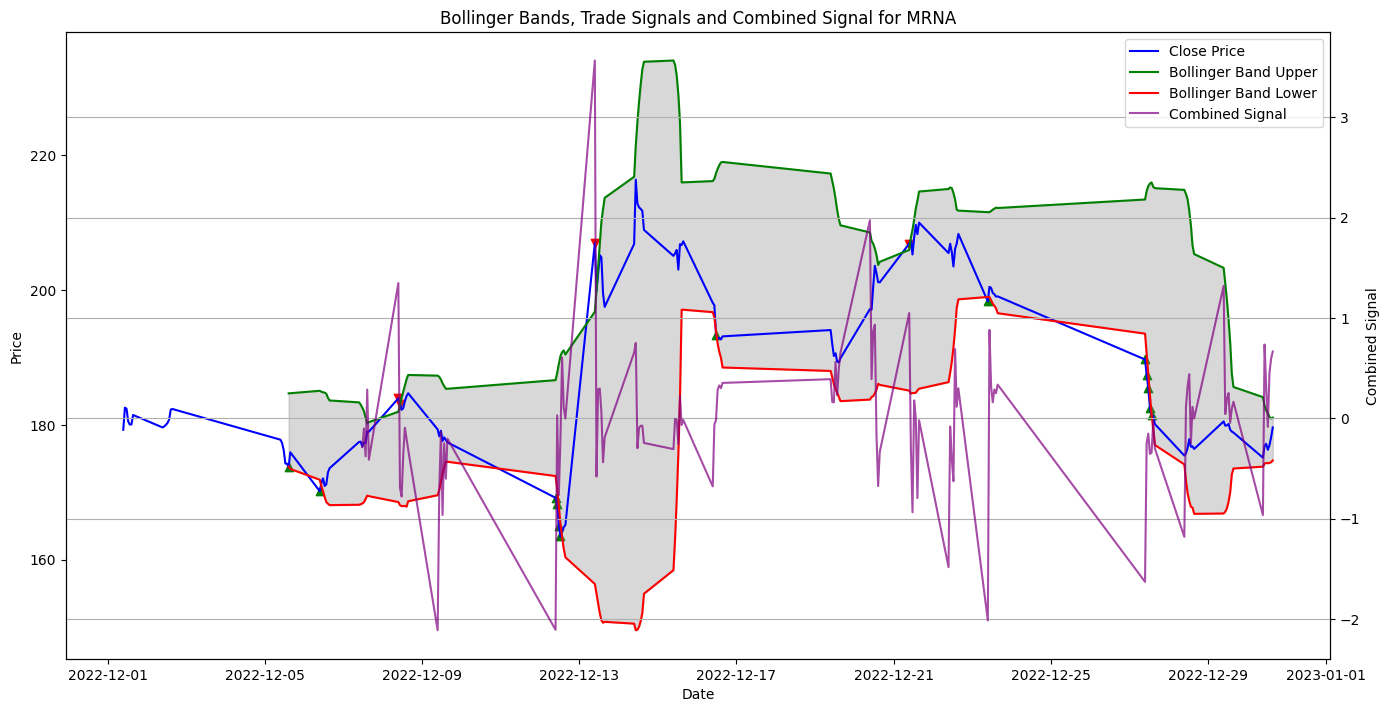

In [97]:
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'AAPL' as one of the most volatile stocks, replace with appropriate stock symbol
ticker = 'MRNA'  
stock_data = data[ticker].copy()
stock_data['Return'] = stock_data['Close'].pct_change()

# Generate Z-Score
stock_data['Z-Score'] = (stock_data['Return'] - stock_data['Return'].rolling(30).mean()) / stock_data['Return'].rolling(30).std()

# Mean Reversion
stock_data['Mean'] = stock_data['Close'].rolling(30).mean()
stock_data['Mean_Reversion_Signal'] = np.where(stock_data['Close'] < stock_data['Mean'], 1, -1)

# Moving Average Crossover
stock_data['SMA20'] = stock_data['Close'].rolling(20).mean()
stock_data['SMA50'] = stock_data['Close'].rolling(50).mean()
stock_data['MAC_Signal'] = np.where(stock_data['SMA20'] > stock_data['SMA50'], 1, -1)

# RSI
stock_data['RSI'] = pta.rsi(stock_data['Close'], length=14)
stock_data['RSI_Signal'] = np.where(stock_data['RSI'] < 30, 1, np.where(stock_data['RSI'] > 70, -1, 0))

# Bollinger Bands
bbands = pta.bbands(stock_data['Close'], length=20)
stock_data['BBUpper'] = bbands['BBU_20_2.0']
stock_data['BBMiddle'] = bbands['BBM_20_2.0']
stock_data['BBLower'] = bbands['BBL_20_2.0']
stock_data['BB_Signal'] = np.where(stock_data['Close'] < stock_data['BBLower'], 1, np.where(stock_data['Close'] > stock_data['BBUpper'], -1, 0))

# Generate combined signal
stock_data['Combined_Signal'] = (stock_data['Z-Score'] * strategy_weights['z_score'] +
                                 stock_data['Mean_Reversion_Signal'] * strategy_weights['mean_reversion'] +
                                 stock_data['MAC_Signal'] * strategy_weights['moving_average_crossover'] +
                                 stock_data['RSI_Signal'] * strategy_weights['rsi'] +
                                 stock_data['BB_Signal'] * strategy_weights['bollinger_bands'])

# Generate signals
stock_data['Long Signal'] = stock_data['Close'] < stock_data['BBLower']
stock_data['Short Signal'] = stock_data['Close'] > stock_data['BBUpper']

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock prices and Bollinger Bands on the first y-axis
ax1.plot(stock_data['Close'], label='Close Price', color='blue')
ax1.plot(stock_data['BBUpper'], label='Bollinger Band Upper', color='green')
ax1.plot(stock_data['BBLower'], label='Bollinger Band Lower', color='red')
ax1.scatter(stock_data[stock_data['Long Signal']].index, stock_data[stock_data['Long Signal']]['Close'], color='green', marker='^')
ax1.scatter(stock_data[stock_data['Short Signal']].index, stock_data[stock_data['Short Signal']]['Close'], color='red', marker='v')
ax1.fill_between(stock_data.index, stock_data['BBLower'], stock_data['BBUpper'], color='grey', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot 'Combined_Signal' on the second y-axis
ax2 = ax1.twinx()
ax2.plot(stock_data.index, stock_data['Combined_Signal'], label='Combined Signal', color='purple', alpha=0.7)
ax2.set_ylabel('Combined Signal')

fig.tight_layout()
plt.title(f'Bollinger Bands, Trade Signals and Combined Signal for {ticker}')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()
